# EMAIL SPAM DETECTION USING NODE CENTRALITY

In [20]:
def func():
    import pandas as pd
    import numpy as np
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, roc_curve, auc
    import networkx as nx
    import matplotlib.pyplot as plt
    from networkx.algorithms.community import greedy_modularity_communities
    import re
    
    
    df = pd.read_csv('email_dataset.csv')  
    # df = pd.read_csv('email_dataset2.csv')  
    
    tfidf_vectorizer = TfidfVectorizer(stop_words="english")
    X_tfidf = tfidf_vectorizer.fit_transform(df["Body"])
    
    G = nx.Graph()
    similarity_matrix = (X_tfidf * X_tfidf.T).toarray()
    threshold = similarity_matrix.mean() 
    
    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            if similarity_matrix[i, j] > threshold:
                G.add_edge(df.at[i, "Account ID"], df.at[j, "Account ID"], weight=similarity_matrix[i, j])
    
    for u, v, d in G.edges(data=True):
        d['weight'] /= similarity_matrix.max()
    
    centrality_measures = {
        'Degree Centrality': nx.degree_centrality(G),
        'Betweenness Centrality': nx.betweenness_centrality(G),
        'Closeness Centrality': nx.closeness_centrality(G),
        'Eigenvector Centrality': nx.eigenvector_centrality(G)
    }
    centrality_df = pd.DataFrame(centrality_measures)
    centrality_df['Spam Label'] = df['Spam Label'].values
    
    communities = list(greedy_modularity_communities(G))
    community_map = {node: i for i, community in enumerate(communities) for node in community}
    centrality_df['Community'] = centrality_df.index.map(community_map)
    
    X_centrality = centrality_df.drop(columns='Spam Label').values
    X_combined = np.hstack([X_tfidf.toarray(), X_centrality, df[['Email Length', 'Number of Links']].values])
    
    X_train, X_test, y_train, y_test = train_test_split(X_combined, df["Spam Label"], test_size=0.3, random_state=42)
    
    param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    classifier = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_test)
    y_prob = classifier.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=1)) 
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    colors = plt.cm.rainbow(np.linspace(0, 1, len(communities)))
    node_community_colors = [colors[community_map[node]] for node in G.nodes()]
    node_sizes = [1000 * centrality_measures['Degree Centrality'][node] for node in G.nodes()]
    
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color=node_community_colors, node_size=node_sizes, with_labels=True, edge_color='gray')
    plt.title("Email Network with Communities Highlighted")
    plt.show()



Accuracy: 0.7000
Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82        42
           1       1.00      0.00      0.00        18

    accuracy                           0.70        60
   macro avg       0.85      0.50      0.41        60
weighted avg       0.79      0.70      0.58        60

Confusion Matrix:
[[42  0]
 [18  0]]


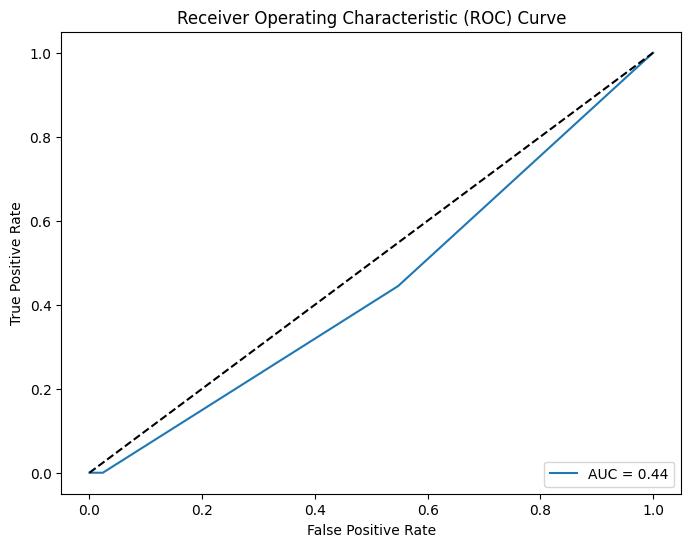

In [21]:
func()